In [23]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

from sklearn.preprocessing import StandardScaler

from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN

from yellowbrick.cluster import KElbowVisualizer,SilhouetteVisualizer
from sklearn.metrics import silhouette_score

from scipy.cluster.hierarchy import linkage, cophenet, dendrogram

np.set_printoptions(suppress=True)   # To avoid number in exp form

from sklearn.metrics.pairwise import euclidean_distances

In [2]:
data=pd.read_csv('tsne_scores.csv')

In [3]:
data.head()

,t-SNE-1,t-SNE-2
0,10.846841,-16.712580
1,24.794334,-16.775398
2,2.953309,13.379048
3,27.262146,-31.886690
4,-23.015728,64.468376


<Axes: xlabel='t-SNE-1', ylabel='t-SNE-2'>

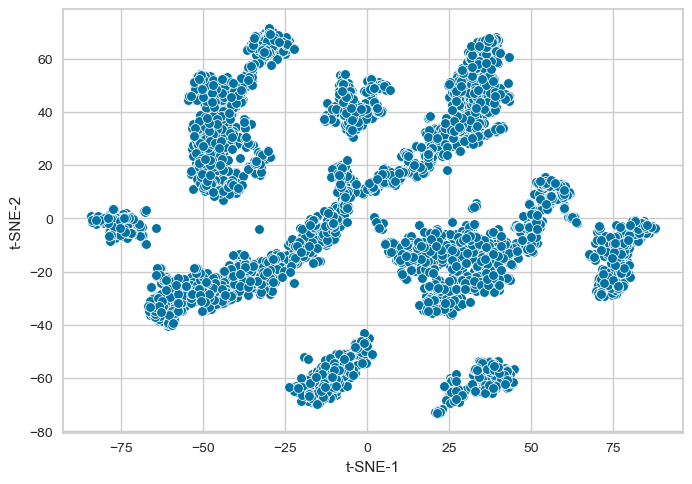

In [4]:
sns.scatterplot(x=data['t-SNE-1'],y=data['t-SNE-2'])

## K_mean Clustering


In [5]:
# Identift the value of K
k_elbow=KElbowVisualizer(KMeans(),k=10)

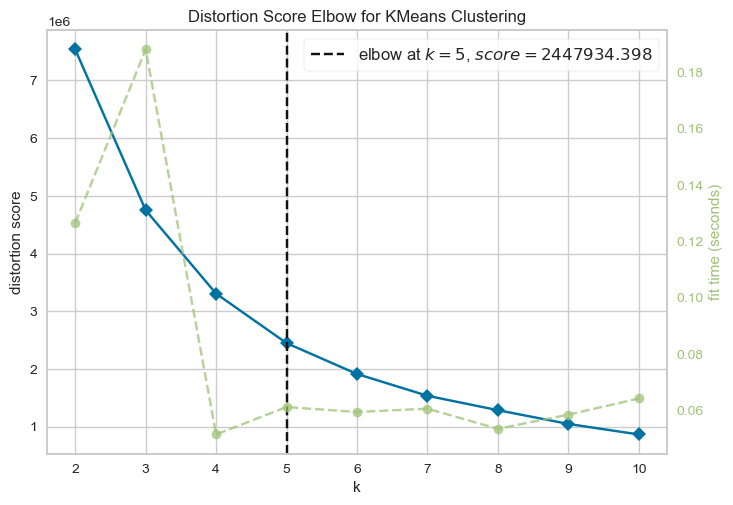

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [6]:
k_elbow.fit(data)
k_elbow.show()

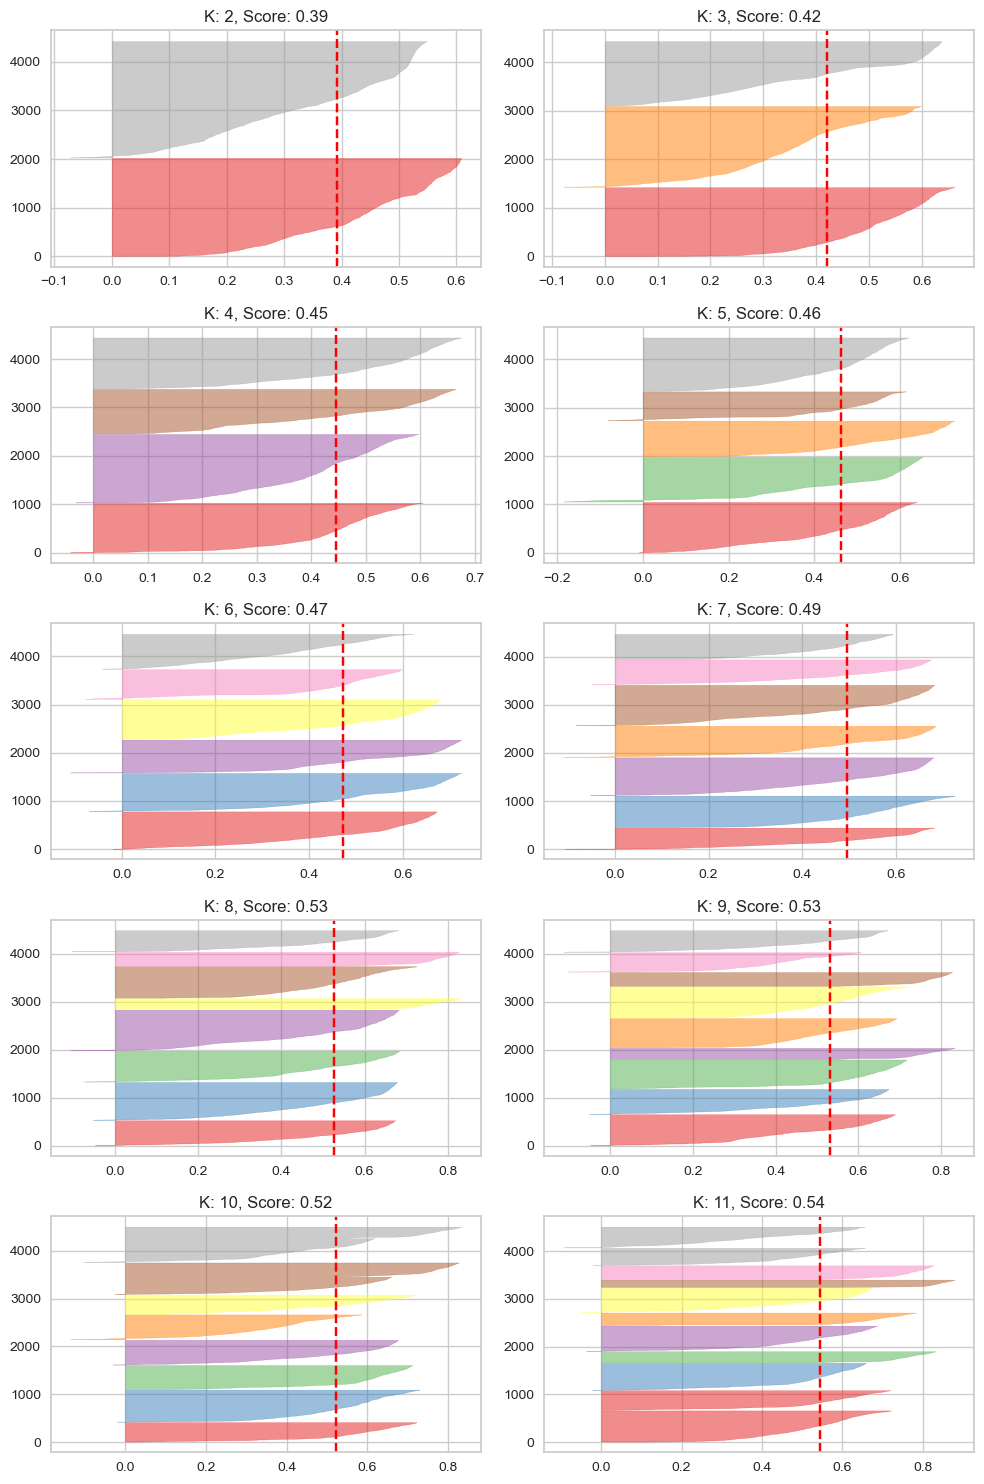

In [7]:
# Better way to visualize the silhouette score is by using yellow brick

t=1
plt.figure(figsize=(10,15))
for i in range(2,12):
    plt.subplot(5,2,t)
    model=KMeans(n_clusters=i)
    sil_viz=SilhouetteVisualizer(model)
    sil_viz.fit(data)
    plt.title(f'K: {i}, Score: {np.round(sil_viz.silhouette_score_,2)}')
    t+=1
plt.tight_layout()
plt.show()

**It is very hard to decide the value of k in this particular case. mainly beacuse of shape of clusters, Even if we go with k=8, let's see what type of clusters we end with**

In [8]:
final_kmeans=KMeans(n_clusters=8)

In [9]:
data['pred_kmeans']=final_kmeans.fit_predict(data)

In [10]:
data.head()

,t-SNE-1,t-SNE-2,pred_kmeans
0,10.846841,-16.712580,4
1,24.794334,-16.775398,4
2,2.953309,13.379048,5
3,27.262146,-31.886690,4
4,-23.015728,64.468376,6


In [11]:
data['pred_kmeans'].value_counts()

pred_kmeans
1    844
6    787
4    656
0    641
3    518
5    439
7    289
2    232
Name: count, dtype: int64

In [12]:
centroids=final_kmeans.cluster_centers_

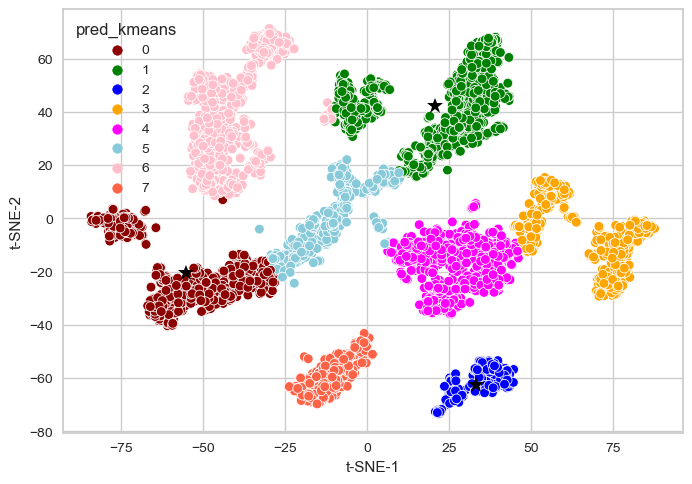

In [13]:
sns.scatterplot(x=data['t-SNE-1'],y=data['t-SNE-2'],hue=data['pred_kmeans'],\
                palette=['darkred','green','blue','orange','magenta','c','pink','tomato'])
for i in range(3):
    plt.plot(centroids[i][0],centroids[i][1],color='black',marker='*',ms=12)
plt.show()

## Agglometrative Clustering

In [14]:
# Lets Create a linkage matrix
link_mat=linkage(data, method='single')  # Method can be single, complete,centroid,ward,average

In [15]:
link_mat.shape

(4405, 4)

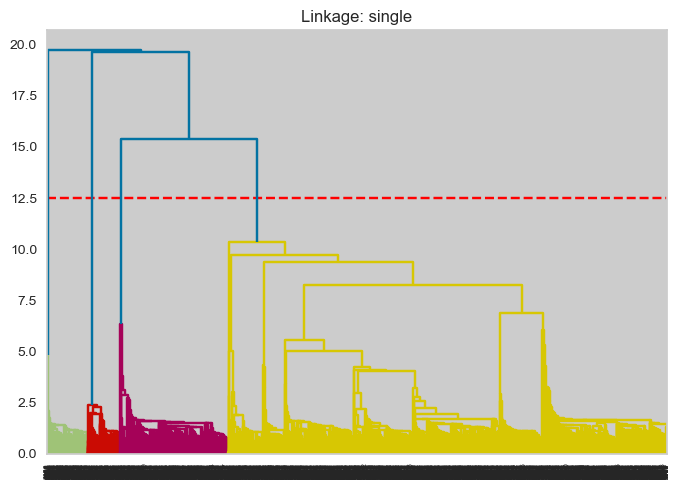

In [16]:
# Dendrogram
plt.title('Linkage: single')
plt.axhline(y=12.5,color='red',ls='--')
dendrogram(link_mat)
plt.show()

In [17]:
# We can use silhouette score to select value of k
for i in range(3,15):
    model= AgglomerativeClustering(n_clusters=i,linkage='single')
    pred=model.fit_predict(data)
    print(i,'k:',silhouette_score(data,pred))

3 k: 0.16343731758444738
4 k: 0.15682881568056947
5 k: 0.012662658295782845
6 k: -0.03292766608173789
7 k: 0.030398572496795756
8 k: 0.15623762675713568
9 k: 0.17751317238178882
10 k: 0.14367083057453636
11 k: 0.06287241205990032
12 k: 0.0349956170243861
13 k: 0.014090058840514967
14 k: -0.01790297530250481


In [18]:
final_agglo=AgglomerativeClustering(n_clusters=9,linkage='single')

In [19]:
data['Pred_agglo']=final_agglo.fit_predict(data)

In [20]:
data.head()

,t-SNE-1,t-SNE-2,pred_kmeans,Pred_agglo
0,10.846841,-16.712580,4,1
1,24.794334,-16.775398,4,1
2,2.953309,13.379048,5,3
3,27.262146,-31.886690,4,1
4,-23.015728,64.468376,6,0


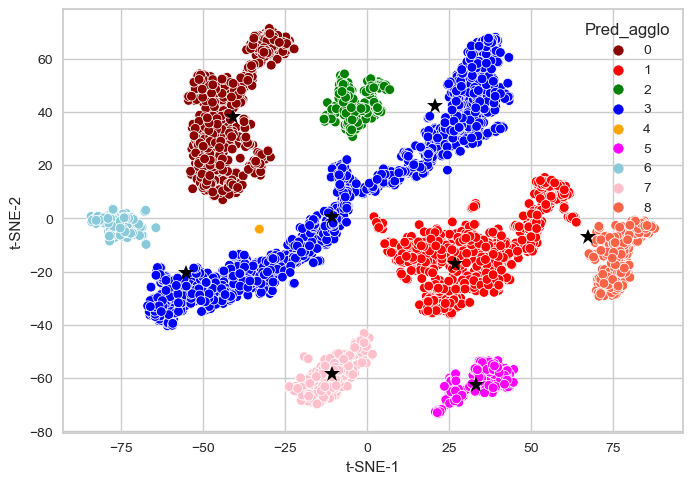

In [21]:
sns.scatterplot(x=data['t-SNE-1'],
                y=data['t-SNE-2'],hue=data['Pred_agglo'],
               palette=['darkred','Red',"green",'blue','orange','magenta','c','pink','tomato','darkgreen'])
for i in range(8):
    plt.plot(centroids[i][0],centroids[i][1],color='black',marker='*',ms=12)
plt.show()

* in this data there is a variation between the datapoints on the basis of density 
* there are non-elipitical or irregular shape in the scatterplot 
* kmeans and agglomertaive clustering they make clusters on the basis of closenss in the data points 
* although you are forming better clusters with agg clustering and linkage=single
* we need some differnt alogorithm for this type of clustering we can try density based clustering (DBSCAN) for this data

## DBSCAN

### First thing to decide is epsilon and min-samples

In [25]:
dist_matrix = euclidean_distances(data)
actual_dist= dist_matrix[np.triu_indices(4406,k=1)]

In [27]:
actual_dist.sort()

In [28]:
actual_dist

array([  0.0054063 ,   0.00578476,   0.00893038, ..., 171.79123969,
       171.9680757 , 172.01171535])

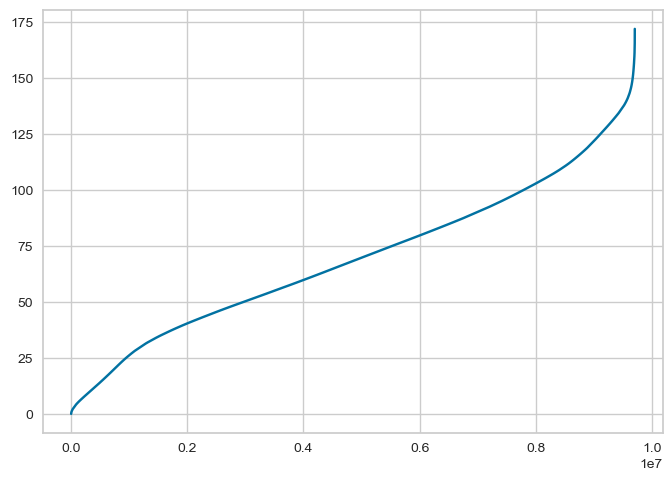

In [29]:
plt.plot(actual_dist)
plt.show()

In [30]:
# epsilon a 5 till 20
# min sample = 5 to 15

In [32]:
epsilon = range(5,21)
min_sample = range(5,15)

for e in epsilon:
    for n in min_sample:
        model=DBSCAN(eps=e,min_samples=n)
        pred= model.fit_predict(data)
        sil= silhouette_score(data,pred)
        print(f'Epsilon {e} and Min Sample {n}: Silhoutee Score {round(sil,2)}')

Epsilon 5 and Min Sample 5: Silhoutee Score 0.22
Epsilon 5 and Min Sample 6: Silhoutee Score 0.22
Epsilon 5 and Min Sample 7: Silhoutee Score 0.22
Epsilon 5 and Min Sample 8: Silhoutee Score 0.23
Epsilon 5 and Min Sample 9: Silhoutee Score 0.28
Epsilon 5 and Min Sample 10: Silhoutee Score 0.28
Epsilon 5 and Min Sample 11: Silhoutee Score 0.28
Epsilon 5 and Min Sample 12: Silhoutee Score 0.34
Epsilon 5 and Min Sample 13: Silhoutee Score 0.34
Epsilon 5 and Min Sample 14: Silhoutee Score 0.34
Epsilon 6 and Min Sample 5: Silhoutee Score 0.1
Epsilon 6 and Min Sample 6: Silhoutee Score 0.1
Epsilon 6 and Min Sample 7: Silhoutee Score 0.1
Epsilon 6 and Min Sample 8: Silhoutee Score 0.1
Epsilon 6 and Min Sample 9: Silhoutee Score 0.24
Epsilon 6 and Min Sample 10: Silhoutee Score 0.24
Epsilon 6 and Min Sample 11: Silhoutee Score 0.24
Epsilon 6 and Min Sample 12: Silhoutee Score 0.24
Epsilon 6 and Min Sample 13: Silhoutee Score 0.24
Epsilon 6 and Min Sample 14: Silhoutee Score 0.24
Epsilon 7 and 

In [59]:
# Epsilon = 7 and mins = 6

In [68]:
final_dbscan= DBSCAN(eps=7, min_samples=9)

In [69]:
data['pred_dbscan']=final_dbscan.fit_predict(data)

In [70]:
data

,t-SNE-1,t-SNE-2,pred_kmeans,Pred_agglo,pred_dbscan
0,10.846841,-16.712580,4,1,0
1,24.794334,-16.775398,4,1,0
2,2.953309,13.379048,5,3,1
3,27.262146,-31.886690,4,1,0
4,-23.015728,64.468376,6,0,2
...,...,...,...,...,...
4401,-15.211057,-69.717155,7,7,7
4402,-9.403443,-62.847458,7,7,7
4403,-17.546083,-10.295582,5,3,1
4404,-8.512799,16.375420,5,3,1


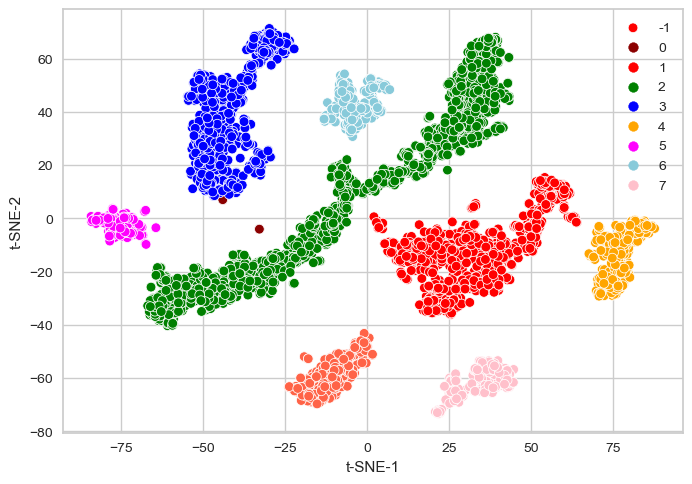

In [73]:
sns.scatterplot(x=data['t-SNE-1'],
                y=data['t-SNE-2'],hue=data['pred_dbscan'],
               palette=['darkred','Red',"green",'blue','orange','magenta','c','pink','tomato','darkgreen'])
plt.legend([-1,0,1,2,3,4,5,6,7])
plt.show()

In [ ]:
data=pd.read_csv('tsne_scores.csv')
from sklearn.neighbors import NearestNeighbors

neighbors= NearestNeighbors(n_neighbors=2)
neighbors.fit(data)

distance,indices=neighbors.kneighbors(data)

In [83]:
data=pd.read_csv('tsne_scores.csv')

In [84]:
from sklearn.neighbors import NearestNeighbors

In [85]:
neighbors= NearestNeighbors(n_neighbors=2)
neighbors.fit(data)

NearestNeighbors(n_neighbors=2)

In [87]:
distance,indices=neighbors.kneighbors(data)

In [88]:
dist=sorted(distance[:,1])

In [89]:
dist

[0.005406299288793922,
 0.005406299288793922,
 0.005784760064163913,
 0.005784760064163913,
 0.008930382130681211,
 0.008930382130681211,
 0.01272084022381559,
 0.01272084022381559,
 0.01321620917661748,
 0.01321620917661748,
 0.015088863377006562,
 0.015088863377006562,
 0.017807383889835948,
 0.017807383889835948,
 0.01900002844735078,
 0.01900002844735078,
 0.019894034176354703,
 0.019894034176354703,
 0.020141748111821147,
 0.020141748111821147,
 0.021391302204400036,
 0.021391302204400036,
 0.021814242411781818,
 0.021814242411781818,
 0.02370853776090056,
 0.02370853776090056,
 0.025070652683966365,
 0.025070652683966365,
 0.0256947171613158,
 0.0256947171613158,
 0.025711059410298182,
 0.025711059410298182,
 0.026503538178889955,
 0.026503538178889955,
 0.027344478418864497,
 0.027344478418864497,
 0.02784968082402382,
 0.02784968082402382,
 0.027961327936991544,
 0.027961327936991544,
 0.029362773302262318,
 0.029362773302262318,
 0.0315885085751123,
 0.0315885085751123,
 0.032

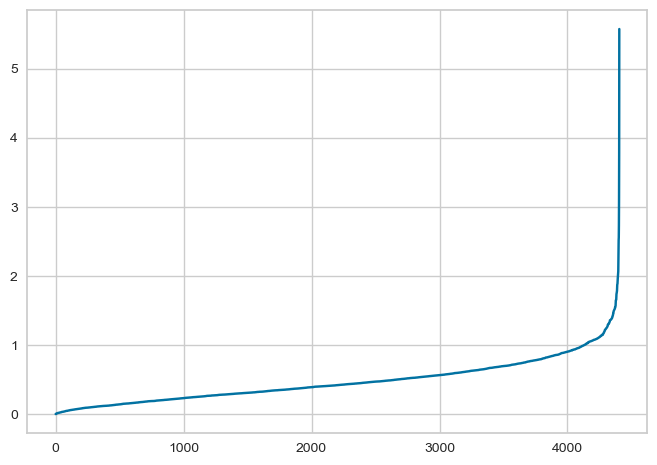

In [90]:
plt.plot(dist)
plt.show()